# Context Distraction

This notebook compares standard ReAct agent performance against a Multi-Agent (supervisor/worker delegation pattern) on context distraction tasks.

## What We're Testing

Both agents answer 8 questions (Q1-8) requiring research across 5 technology domains. The Multi-Agent uses a supervisor that delegates to workers with isolated context, while the Standard Agent processes everything in a single context.

**Hypothesis**: Multi-Agent's context isolation should improve recall accuracy on multi-step tasks.

## Setup

In [1]:
# Imports and Setup
import asyncio
from typing import Dict, Any, List
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from dotenv import load_dotenv

load_dotenv(override=True)

# Import test infrastructure
from context_distraction.resources.test_tasks import TEST_TASKS, build_partial_task
from context_distraction.tests.evaluators import recall_accuracy_evaluator
from context_distraction.tests.setup_datasets import build_reference_outputs
from context_distraction.resources.validation_utils import extract_tool_calls_from_message

# Import agents
from context_distraction.agent import agent as standard_agent
from context_distraction.multi import run_multi_agent

print("Setup complete")

Setup complete


## Test Configuration

Running Q1-8 on all 3 tasks with multiple trials to measure consistency.

In [2]:
# Configuration
QUESTIONS = [1, 2, 3, 4, 5, 6, 7, 8]  # Q1-8
NUM_TRIALS = 3  # Run each test multiple times

print(f"Test Configuration:")
print(f"  Questions: {QUESTIONS}")
print(f"  Trials per task: {NUM_TRIALS}")
print(f"\nTasks:")
for i, task in enumerate(TEST_TASKS, 1):
    print(f"  Task {i}: {task['name']} (focus: {task['primary_domain']})")

Test Configuration:
  Questions: [1, 2, 3, 4, 5, 6, 7, 8]
  Trials per task: 3

Tasks:
  Task 1: Task 1: 5 Domains - Focus on Renewable Energy (focus: renewable_energy)
  Task 2: Task 2: 5 Domains - Focus on Electric Vehicles (focus: electric_vehicles)
  Task 3: Task 3: 5 Domains - Focus on Biotechnology (focus: biotechnology)


## Agent Runner Functions

In [3]:
async def run_standard(query: str) -> dict:
    """Run standard agent and extract outputs."""
    try:
        trajectory = []
        final_response = ""
        all_messages = []
        
        async for chunk in standard_agent.astream(
            {"messages": [("user", query)]},
            stream_mode="updates",
        ):
            if isinstance(chunk, dict):
                for key in ['tools', 'model']:
                    if key in chunk:
                        msgs = chunk[key].get('messages', [])
                        all_messages.extend(msgs)
                        for msg in msgs:
                            tool_calls = extract_tool_calls_from_message(msg)
                            trajectory.extend(tool_calls)
        
        for msg in reversed(all_messages):
            if hasattr(msg, 'content') and msg.content:
                final_response = msg.content
                break
        
        return {"final_response": final_response, "trajectory": trajectory, "error": None}
    except Exception as e:
        return {"final_response": "", "trajectory": [], "error": str(e)}

async def run_test(task_idx: int, questions: list, agent_type: str) -> dict:
    """Run a single test and return results."""
    task = TEST_TASKS[task_idx]
    partial_task = build_partial_task(task, questions)
    reference = build_reference_outputs(partial_task)
    inputs = {"query": partial_task["query"]}
    
    if agent_type == "standard":
        outputs = await run_standard(inputs["query"])
    else:
        outputs = await run_multi_agent(inputs["query"])
    
    if outputs.get("error"):
        return {"score": 0.0, "error": outputs["error"], "correct": 0, "total": len(questions)}
    
    result = recall_accuracy_evaluator(inputs, outputs, reference)
    return {
        "score": result["score"],
        "error": None,
        "correct": int(result["score"] * len(questions)),
        "total": len(questions)
    }

print("Runner functions defined")

Runner functions defined


## Run All Tests

Running {NUM_TRIALS} trials for each task/agent combination.

In [4]:
# Run all tests
all_results = []

for task_idx in range(len(TEST_TASKS)):
    task = TEST_TASKS[task_idx]
    print(f"\n{'='*60}")
    print(f"Task {task_idx + 1}: {task['name']}")
    print(f"{'='*60}")
    
    for trial in range(NUM_TRIALS):
        print(f"\n  Trial {trial + 1}/{NUM_TRIALS}")
        
        # Run standard agent
        print(f"    Standard agent...", end=" ", flush=True)
        std_result = await run_test(task_idx, QUESTIONS, "standard")
        std_status = f"{std_result['correct']}/{std_result['total']}" if not std_result['error'] else "ERROR"
        print(std_status)
        
        # Run multi-agent  
        print(f"    Multi-agent...", end=" ", flush=True)
        multi_result = await run_test(task_idx, QUESTIONS, "multi")
        multi_status = f"{multi_result['correct']}/{multi_result['total']}" if not multi_result['error'] else "ERROR"
        print(multi_status)
        
        all_results.append({
            'task': task_idx + 1,
            'task_name': task['name'],
            'trial': trial + 1,
            'standard_score': std_result['score'],
            'standard_correct': std_result['correct'],
            'multi_score': multi_result['score'],
            'multi_correct': multi_result['correct'],
            'total': std_result['total']
        })

print(f"\n{'='*60}")
print("All tests completed!")
print(f"{'='*60}")


Task 1: Task 1: 5 Domains - Focus on Renewable Energy

  Trial 1/3
    Standard agent... 1/8
    Multi-agent... 4/8

  Trial 2/3
    Standard agent... 1/8
    Multi-agent... 5/8

  Trial 3/3
    Standard agent... 1/8
    Multi-agent... 4/8

Task 2: Task 2: 5 Domains - Focus on Electric Vehicles

  Trial 1/3
    Standard agent... 1/8
    Multi-agent... 3/8

  Trial 2/3
    Standard agent... 1/8
    Multi-agent... 2/8

  Trial 3/3
    Standard agent... 1/8
    Multi-agent... 3/8

Task 3: Task 3: 5 Domains - Focus on Biotechnology

  Trial 1/3
    Standard agent... 3/8
    Multi-agent... 5/8

  Trial 2/3
    Standard agent... 3/8
    Multi-agent... 4/8

  Trial 3/3
    Standard agent... 3/8
    Multi-agent... 5/8

All tests completed!


## Results Summary

In [5]:
# Create results dataframe
df = pd.DataFrame(all_results)

# Summary by task
print("Results by Task (averaged across trials):")
print("-" * 50)
task_summary = df.groupby('task').agg({
    'standard_score': ['mean', 'std'],
    'multi_score': ['mean', 'std'],
    'standard_correct': 'mean',
    'multi_correct': 'mean',
    'total': 'first'
}).round(3)

for task_idx in range(1, len(TEST_TASKS) + 1):
    task_data = df[df['task'] == task_idx]
    std_mean = task_data['standard_score'].mean()
    std_std = task_data['standard_score'].std()
    multi_mean = task_data['multi_score'].mean()
    multi_std = task_data['multi_score'].std()
    
    print(f"\nTask {task_idx}: {TEST_TASKS[task_idx-1]['name']}")
    print(f"  Standard: {std_mean:.1%} +/- {std_std:.1%}")
    print(f"  Multi:    {multi_mean:.1%} +/- {multi_std:.1%}")
    print(f"  Winner:   {'Multi' if multi_mean > std_mean else 'Standard' if std_mean > multi_mean else 'Tie'}")

# Overall summary
print("\n" + "=" * 50)
print("OVERALL RESULTS")
print("=" * 50)
std_overall = df['standard_score'].mean()
multi_overall = df['multi_score'].mean()
print(f"  Standard Agent: {std_overall:.1%}")
print(f"  Multi-Agent:    {multi_overall:.1%}")
print(f"  Improvement:    {(multi_overall - std_overall)*100:+.1f} percentage points")
print(f"\n  Multi-agent wins: {(df['multi_score'] > df['standard_score']).sum()}/{len(df)} trials")
print(f"  Standard wins:    {(df['standard_score'] > df['multi_score']).sum()}/{len(df)} trials")
print(f"  Ties:             {(df['standard_score'] == df['multi_score']).sum()}/{len(df)} trials")

Results by Task (averaged across trials):
--------------------------------------------------

Task 1: Task 1: 5 Domains - Focus on Renewable Energy
  Standard: 12.5% +/- 0.0%
  Multi:    54.2% +/- 7.2%
  Winner:   Multi

Task 2: Task 2: 5 Domains - Focus on Electric Vehicles
  Standard: 12.5% +/- 0.0%
  Multi:    33.3% +/- 7.2%
  Winner:   Multi

Task 3: Task 3: 5 Domains - Focus on Biotechnology
  Standard: 37.5% +/- 0.0%
  Multi:    58.3% +/- 7.2%
  Winner:   Multi

OVERALL RESULTS
  Standard Agent: 20.8%
  Multi-Agent:    48.6%
  Improvement:    +27.8 percentage points

  Multi-agent wins: 9/9 trials
  Standard wins:    0/9 trials
  Ties:             0/9 trials


## Detailed Results Table

### All Trial Results

,Task,Trial,Standard Correct,Multi Correct,Total Questions,Standard Score,Multi Score
0,1,1,1,4,8,0.125,0.500
1,1,2,1,5,8,0.125,0.625
2,1,3,1,4,8,0.125,0.500
3,2,1,1,3,8,0.125,0.375
4,2,2,1,2,8,0.125,0.250
5,2,3,1,3,8,0.125,0.375
6,3,1,3,5,8,0.375,0.625
7,3,2,3,4,8,0.375,0.500
8,3,3,3,5,8,0.375,0.625


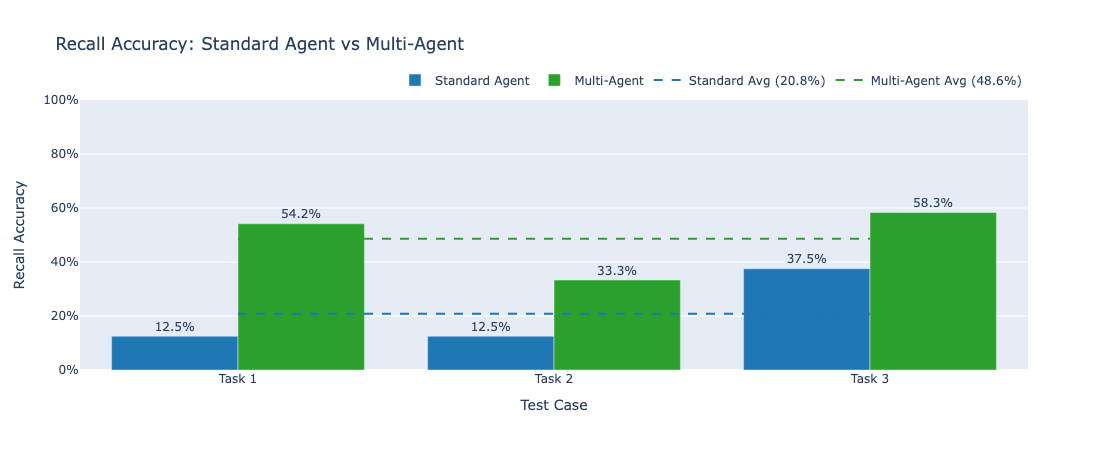

In [6]:
# Display full results table
display(Markdown("### All Trial Results"))
display(df[['task', 'trial', 'standard_correct', 'multi_correct', 'total', 'standard_score', 'multi_score']]
        .rename(columns={
            'task': 'Task',
            'trial': 'Trial', 
            'standard_correct': 'Standard Correct',
            'multi_correct': 'Multi Correct',
            'total': 'Total Questions',
            'standard_score': 'Standard Score',
            'multi_score': 'Multi Score'
        }))

# Visualization
import plotly.graph_objects as go

# Calculate averages per task
task_avgs = df.groupby('task').agg({
    'standard_score': 'mean',
    'multi_score': 'mean'
}).reset_index()

tasks = [f"Task {i}" for i in task_avgs['task']]
std_scores = task_avgs['standard_score'].tolist()
multi_scores = task_avgs['multi_score'].tolist()

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Standard Agent',
    x=tasks,
    y=std_scores,
    marker_color='#1f77b4',
    text=[f"{s:.1%}" for s in std_scores],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Multi-Agent',
    x=tasks,
    y=multi_scores,
    marker_color='#2ca02c',
    text=[f"{s:.1%}" for s in multi_scores],
    textposition='outside'
))

# Add average lines
std_avg = df['standard_score'].mean()
multi_avg = df['multi_score'].mean()

fig.add_trace(go.Scatter(
    x=tasks,
    y=[std_avg] * len(tasks),
    mode='lines',
    name=f'Standard Avg ({std_avg:.1%})',
    line=dict(color='#1f77b4', width=2, dash='dash'),
))

fig.add_trace(go.Scatter(
    x=tasks,
    y=[multi_avg] * len(tasks),
    mode='lines',
    name=f'Multi-Agent Avg ({multi_avg:.1%})',
    line=dict(color='#2ca02c', width=2, dash='dash'),
))

fig.update_layout(
    title="Recall Accuracy: Standard Agent vs Multi-Agent",
    xaxis_title="Test Case",
    yaxis_title="Recall Accuracy",
    barmode='group',
    height=450,
    yaxis=dict(range=[0, 1.0], tickformat='.0%'),
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

## Comparing the Two Approaches

| Aspect | Standard ReAct Agent | Multi-Agent (Supervisor/Worker) |
|--------|---------------------|--------------------------------|
| **Architecture** | Single agent processes all questions | Supervisor delegates to isolated workers |
| **Context** | All tool calls accumulate in one history | Each worker has fresh, isolated context |
| **Execution** | Sequential tool calls in shared state | Parallel workers with independent state |
| **Pros** | Simple implementation, direct context access | Context isolation, focused workers, structured decomposition |
| **Cons** | Context grows unbounded, values get "lost" | More complex, delegation overhead, supervisor accuracy matters |
| **Best for** | Simple, single-domain tasks | Complex, multi-domain tasks with many data points |

## Key Takeaways

The Multi-Agent's context isolation approach shows promise for reducing confusion in multi-domain tasks:
- Workers process one sub-task at a time without accumulated context noise
- Explicit delegation forces task decomposition
- Results are explicitly passed back rather than implicitly remembered

### When to Use Each Approach

| Aspect | Standard Agent | Multi-Agent |
|--------|----------------|-------------|
| **Best for** | Simple, single-domain tasks | Complex, multi-domain tasks |
| **Context size** | Grows unbounded | Isolated per worker |
| **Complexity** | Low | Higher |
| **Latency** | Lower | Higher (multiple agent calls) |